# [CDAF] Atividade 2

## Nome e matrícula
Nome: Luís Felipe Ramos Ferreira
Matrícula: 2019022553

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre estatísticas agregadas. Para esta atividade, usaremos dados do Brasileirão 2022 do FBRef.

## Questão 1
- Baixe o dataset de resultados em https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures
- Crie uma média móvel de 5 jogos, para cada equipe, de cada uma das seguintes estatísticas: xG pró, xG contra, e dif. xG.
- Escolha 4 times para visualizar a série temporal das estatísticas acima. Uma visualização para cada uma das estatísticas, onde a média geral do campeonato é apresentada com uma linha pontilhada em conjunto com a média móvel dos times escolhidos.
- Interprete os resultados. O que isso pode indicar sobre a qualidade ofensiva e defensiva dos times escolhidos?

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from mplsoccer import PyPizza, FontManager
warnings.filterwarnings('ignore')

In [46]:
df: pd.DataFrame = pd.read_csv("../data/atv02/sportsref.csv")
df.drop(columns=["Day", "Time", "Date", "Attendance", "Venue", "Referee", "Match Report", "Notes"], inplace=True)
df.rename(columns={"xG": "xG_Home", "xG.1": "xG_Away"}, inplace=True)
df["xG_diff"] = df["xG_Home"] - df["xG_Away"]
df

,Wk,Home,xG_Home,Score,xG_Away,Away,xG_diff
0,1,Fluminense,1.6,0–0,0.1,Santos,1.5
1,1,Atl Goianiense,1.4,1–1,1.2,Flamengo,0.2
2,1,Coritiba,1.7,3–0,0.4,Goiás,1.3
3,1,Atlético Mineiro,1.9,2–0,0.6,Internacional,1.3
4,1,Botafogo (RJ),1.5,1–3,2.1,Corinthians,-0.6
...,...,...,...,...,...,...,...
375,38,Bragantino,0.9,0–1,0.6,Fluminense,0.3
376,38,América (MG),2.1,1–1,0.5,Atl Goianiense,1.6
377,38,Goiás,0.2,0–4,1.7,São Paulo,-1.5
378,38,Internacional,1.4,3–0,1.3,Palmeiras,0.1


In [47]:
teams: np.array = df["Home"].unique()
xG_pro_global_moving_average: np.array = np.zeros(38)
xG_against_global_moving_average: np.array = np.zeros(38)
xG_diff_global_moving_average: np.array = np.zeros(38)
window_size: int = 5
for team in teams:
    team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
    team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
    team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
    team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

    xG_pro_moving_average: np.array = team_df["xG_pro"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_against_moving_average: np.array = team_df["xG_against"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_diff_moving_average: np.array = team_df["xG_diff"].rolling(window=window_size, min_periods=1).mean().to_numpy()

    """ plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label="Pro")
    plt.plot(np.arange(38), xG_against_moving_average, marker='o', linewidth=1, markersize=2, label="Against")
    plt.plot(np.arange(38), xG_diff_moving_average,  marker='o', linewidth=1, markersize=2, label="Difference")
    plt.title(f"{team} moving averages")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend()
    plt.show() """

    xG_pro_global_moving_average += xG_pro_moving_average
    xG_against_global_moving_average = xG_against_moving_average
    xG_diff_global_moving_average += xG_diff_moving_average

xG_pro_global_moving_average /= 20
xG_against_global_moving_average /= 20
xG_diff_global_moving_average /= 20


Para análise, foram escolhidos os clubes que ficaram em 1º, 7º, 13º e 20º colocados no campeonato brasileiro de 2022, uma vez que são clubes espaçados em colocação de forma balanceada, o que irá permitir análises de diferentes casos de performance durante o campeonato. Respectivamente, se tratam dos clubes: Palmeiras, Atlético Mineiro, Goiás e Juventude.

In [48]:
def plot_teams_moving_averages(df: pd.DataFrame, statistic: str, teams: np.array, global_moving_average: np.array, window_size: int) -> None:
    for team in teams:
        team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
        team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
        team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
        team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

        xG_pro_moving_average: np.array = team_df[statistic].rolling(window=window_size, min_periods=1).mean().to_numpy()
        plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label=team)
        
    plt.plot(np.arange(38), global_moving_average,  linestyle="--", marker='o', linewidth=1, markersize=2, label="Global average")
    plt.title(f"Moving average of {statistic} for {teams}")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend(loc=(0.1, 0.775), fontsize="6.5")
    plt.show()

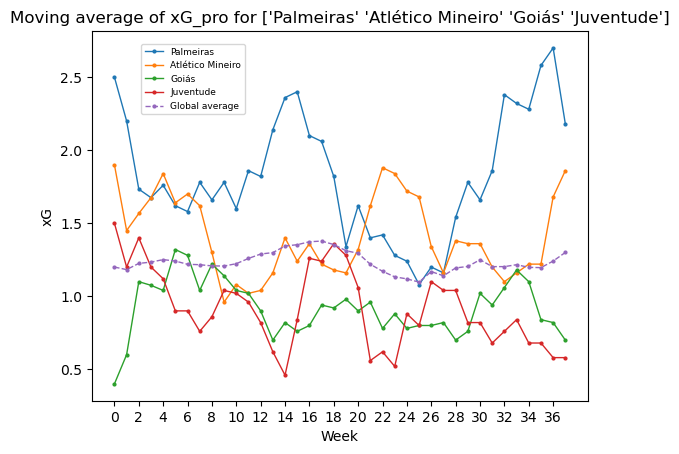

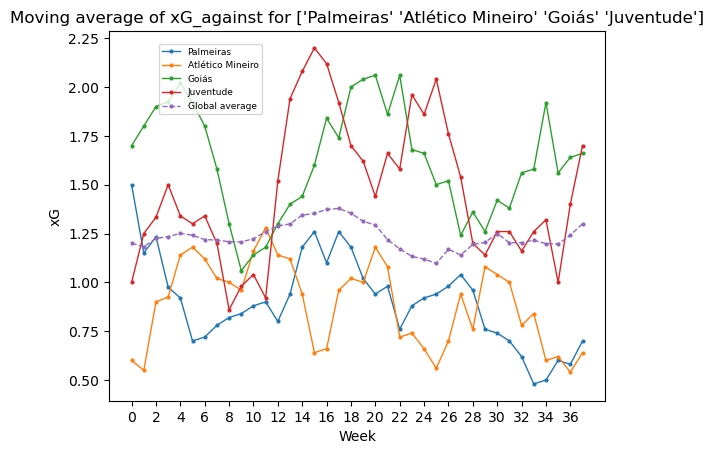

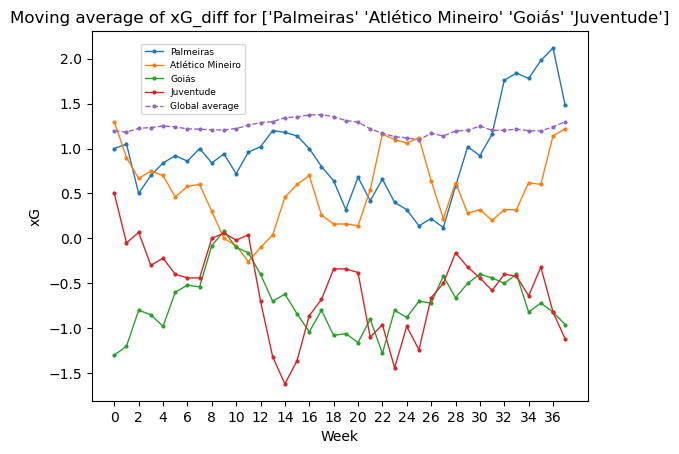

In [49]:
teams: np.array = np.array(["Palmeiras", "Atlético Mineiro", "Goiás", "Juventude"])
statistics: np.array = np.array(["xG_pro", "xG_against", "xG_diff"])
for statistic in statistics:
    plot_teams_moving_averages(df=df, statistic=statistic, teams=teams, global_moving_average=xG_pro_global_moving_average, window_size=window_size)


Em um primeiro momento, é interessante analisar como a média móvel de *xG_pro* e *xG_against* acompanham a posição relativa dos times no campeonato. O Palmeiras, como campeão, está com uma média praticamente sempre "acima" dos outros clubes analisados no quesito gols esperados a favor, enquanto, análogamente, está quase sempre "abaixo" dos outros em relação a gols esperados contra. A mesma situação se repete para o Juventude, último colocado, só que de maneira inversa, conforme podemos esperar. Evidentemente, isso não estabelece uma regra. O Atlético Mineiro, 7º colocado, teve uma média de *xG_against* muito parecida com a do Palmeiras, assim como também teve períodos ao longo do campeonato em que sua média de *xG_pro* foi superior à do campeão.

Em relação ao desempenho dos times, fica claro que aqueles que estão na parte de cima da tabela possuem maior qualidade, tanto ofensivamente quanto defensivamente. Pode-se ver como o Palmeiras e o Atlético Mineiro tem suas séries de médias móveis de *xG_pro* acima da média global e *xG_against* abaixo da média global, de maneira generalizada. O mesmo ocorre de maneira inversa para Goiás e Juventude. Podemos inferir disso então que clubes que ficaram em boas colocações no campeonato possuem proporções de gols feitos esperados acima da média e gols tomados esperados abaixo da média.

O gráfico da média móvel de *xG_diff* nos mostra qye todos os clubes ficaram, praticamente todo o tempo, abaixo do valor médio global, que está em cada período de análise entre 1.0 e 1.5. Disso, podemos ver como o modelo utilizado pode superestimar o número de gols feitos pelo time vencedor de uma partida e subestimar o número de gols feitos pelo time perdedor.

FALAR MAIS AQUI

## Questão 2
- Agora repita a questão 1, plotando as séries temporais dos mesmos times, mas para uma janela móvel de 10 jogos.
- Quais as diferenças entre as séries temporais de 5 e 10 jogos? Em quais situações pode ser vantajoso escolher uma janela à outra?

In [50]:
teams: np.array = df["Home"].unique()
xG_pro_global_moving_average: np.array = np.zeros(38)
xG_against_global_moving_average: np.array = np.zeros(38)
xG_diff_global_moving_average: np.array = np.zeros(38)
window_size: int = 10
for team in teams:
    team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
    team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
    team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
    team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

    xG_pro_moving_average: np.array = team_df["xG_pro"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_against_moving_average: np.array = team_df["xG_against"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_diff_moving_average: np.array = team_df["xG_diff"].rolling(window=window_size, min_periods=1).mean().to_numpy()

    """ plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label="Pro")
    plt.plot(np.arange(38), xG_against_moving_average, marker='o', linewidth=1, markersize=2, label="Against")
    plt.plot(np.arange(38), xG_diff_moving_average,  marker='o', linewidth=1, markersize=2, label="Difference")
    plt.title(f"{team} moving averages")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend()
    plt.show() """

    xG_pro_global_moving_average += xG_pro_moving_average
    xG_against_global_moving_average = xG_against_moving_average
    xG_diff_global_moving_average += xG_diff_moving_average

xG_pro_global_moving_average /= 20
xG_against_global_moving_average /= 20
xG_diff_global_moving_average /= 20

Os mesmos 4 clubes serão escolhidos, pelo mesmo motivo anterior.

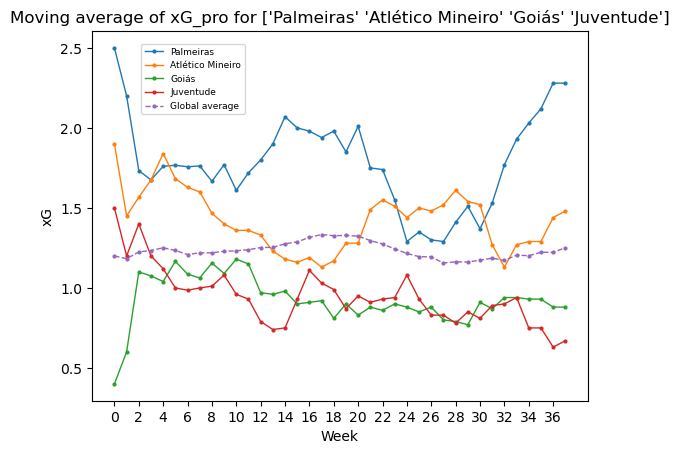

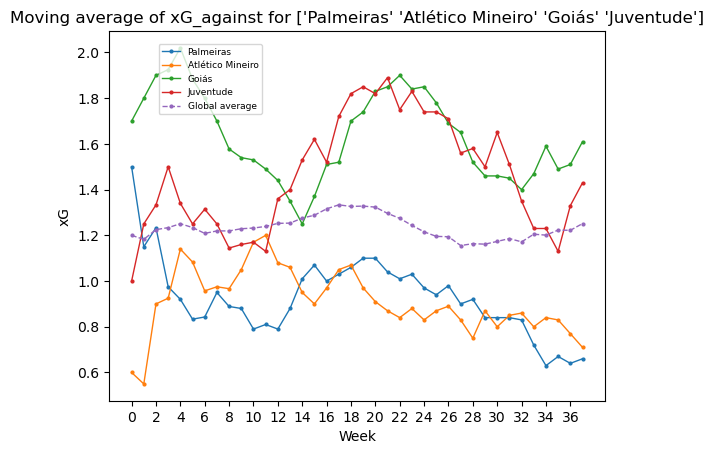

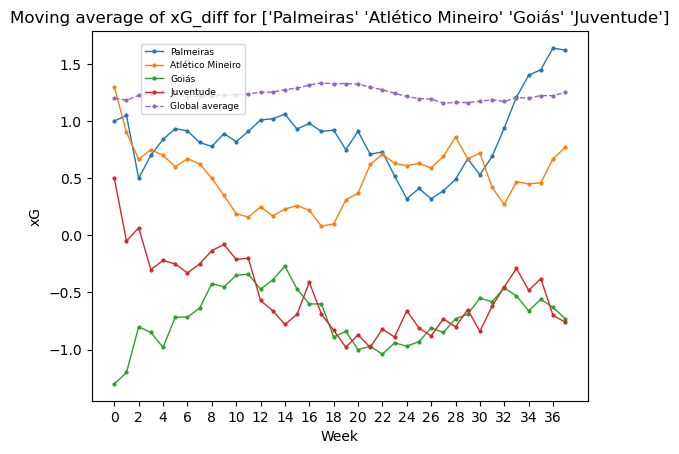

In [51]:
statistics: np.array = np.array(["xG_pro", "xG_against", "xG_diff"])
teams: np.array = np.array(["Palmeiras", "Atlético Mineiro", "Goiás", "Juventude"])
for statistic in statistics:
    plot_teams_moving_averages(df=df, statistic=statistic, teams=teams, global_moving_average=xG_pro_global_moving_average, window_size=window_size)

A janela temporal de 10 jogos traz um grau de informação maior, uma vez que mais jogos são utilizados no cálculo da média representativa de cada período de análise da série temporal gerada.

## Questão 3
- Vá para o link
-- https://fbref.com/en/comps/24/2022/stats/2022-Serie-A-Stats
- Nesta seção de estatísticas, é possível navegar por estatísticas específicas para diferentes aspectos do jogo (finalização, passe, defesa, etc.). Para todos exercícios à partir deste, você terá que selecionar aquelas que julgar mais relevantes para responder as questões.
- Monte um radar plot com 6 atributos relevantes para atacantes e compare 3 jogadores de sua escolha. Justifique a escolha de cada um dos atributos, a escolha da escala dos radares e o tipo de normalização. Interprete os resultados dos radares em termos das qualidades e limitações dos jogadores.
- Ref Soccermatics:
-- https://soccermatics.readthedocs.io/en/lafowards/lesson3/ScoutingPlayers.html
-- https://soccermatics.readthedocs.io/en/lafowards/gallery/lesson3/plot_RadarPlot.html

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- xG (Expected Goals): O principal objetivo do futebol é marcar gols e vencer a partida, e os atacantes são os jogadores cuja função principal é marcar esses gols. A média esperada de gols no campeonato é uma importante métrica para analisarmos quão impactante o atacante será nos campeonatos.

- PrgC (Progressive Carries): Caracterítisca importante para que possamos analisar como os atacantes se comportam na condução de bola, isto é, se possuem foco em apenas recebr a bola e finalizar, ou se possuem foco em conduzila até o gol adversário e auxiliar a equipe an conversão dos gols.

- PrgR (Progressive Passes Received): Pelos mesmos motivos do atributo *PrgC*, poderemos ver como os atacantes analisados se comportam em relação à lances progressivos.

- GlsP90 (Goals Per 90 Minutes): Pelas mesmas justificativas abordadas no tópico da métrica *xG*, poderemos ver quantos gols o atacante de fato fez por partida.

- xGP90 (Expected Goals Per 90 Minutes): Pelas mesmas justificativas abordadas no tópico da métrica *xG*, poderemos ver quantos gols espera-se que o atacante faça por partida.

- npxG (Non Penalty Expected Goals): Com essa métrica atrelada à *xGP90*, poderemos analisar quão dependente de penalisades máximas o jogador é para marcar gols e causar imapcto nas partidas. Isso é importante principalmente considerando o enorme número de memes e piadas na internet direcionados a jogadores que supostamente dependem dos pênaltis para contribuírem para a partida.

Os três jogadores escolhidos serão:

- Pedro (Flamengo)

- Dudu (Palmeiras)

- Hulk (Atlético Mineiro)

Como a temporada analisada é o campeonato brasileiro de 2022, acredito que seja interessante analisar os principais atacantes do país nos últimos anos. São jogadores referências nos clubes que mais se destcaram e venceram títulos desde 2018.

A escala dos radares foi feita com base em percentis calculados a partir dos menores e maiores valores de cada uma das colunas/atributos escolhidos. Dessa forma, poderemos enxergar uma métrica mostrando quão bom o jogador foi na temporada, considerando aquele atributo, numa escala em que 0% seria o pior caso possivel, e 100% seria o melhor caso possível. Para garantir dados limpos e concretos, foram filtrados apenas os atacantes ("FW") com mais de 25 partidas jogadas, com o intuito de evitar o encontro de *outliars* que poderiam gerar confusão.

Um bom exemplo seria o caso do atributo *Expected Goals per 90 minutes*. O jogador Werton do Flamengo possui o valor extremamente alto de 3.1 para esta coluna mas, no entanto, este cálculo se deve ao fato de que ele jogou apenas duas partidas no campeonato. Um número maior de jogos refletiria num valor muito mais realista para o atleta. Por isso, essa filtragem foi realizada. A quantidade de 25 partidas jogadas como média de corte foi escolhida de forma arbitrária, portanto outros valores poderiam gerar resultados melhores para visualizações, embora o número escolhido tenha se mostrado suficiente para as análises.

In [52]:
df: pd.DataFrame = pd.read_csv("../data/atv02/player_standard_stats.csv")
df.drop(columns=["Rk", "Nation", "Age", "Starts", "Born", "Min", "90s", "Matches", "-9999"], inplace=True) # removendo colunas "inúteis"
df.rename(columns={"Gls.1": "GlsP90", "Ast.1": "AstP90", "G+A.1": "G+AP90", "G-PK.1": "G-PKP90", "xG.1": "xGP90", "xAG.1": "xAGP90", "npxG.1": "npxGP90", "npxG+xAG.1": "npxG+xAGP90"}, inplace=True)

In [53]:
df

,Player,Pos,Squad,MP,Gls,Ast,G+A,G-PK,PK,PKatt,...,GlsP90,AstP90,G+AP90,G-PKP90,G+A-PK,xGP90,xAGP90,xG+xAG,npxGP90,npxG+xAGP90
0,Abner,DF,Atl Paranaense,28,1,2,3,1,0,0,...,0.04,0.09,0.13,0.04,0.13,0.05,0.09,0.15,0.05,0.15
1,Adryelson,DF,Botafogo (RJ),17,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.08,0.02,0.10,0.08,0.10
2,Adson,FWMF,Corinthians,25,3,0,3,3,0,0,...,0.22,0.00,0.22,0.22,0.22,0.19,0.06,0.25,0.19,0.25
3,Airton,FW,Atl Goianiense,33,2,4,6,2,0,0,...,0.10,0.21,0.31,0.10,0.31,0.19,0.14,0.34,0.19,0.34
4,Carlos Alberto,FWMF,América (MG),6,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.41,0.06,0.47,0.41,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,Yago,MFDF,Fluminense,21,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.16,0.11,0.27,0.16,0.27
759,Ytalo,FW,Bragantino,11,3,0,3,3,0,0,...,0.43,0.00,0.43,0.43,0.43,0.18,0.04,0.22,0.18,0.22
760,Marcos Ytalo,DF,Ceará,2,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.08,0.07,0.15,0.08,0.15
761,Vinícius Zanocelo,MF,Santos,28,3,0,3,3,0,0,...,0.13,0.00,0.13,0.13,0.13,0.15,0.06,0.21,0.15,0.21


In [54]:
hulk_series: pd.Series = df[(df["Player"] == "Hulk") & (df["Squad"] == "Atlético Mineiro")]
pedro_series: pd.Series = df[(df["Player"] == "Pedro") & (df["Squad"] == "Flamengo")]
rony_series: pd.Series = df[(df["Player"] == "Dudu") & (df["Squad"] == "Palmeiras")]

names = ["xG", "npxG", "PrgC", "PrgR", "GlsP90", "xGP90"]
fowards = df[(df["Pos"].str.contains("FW")) & (df["MP"] >= 25)].describe()[names]
max_values: np.array = fowards.loc["max"].to_numpy()
min_values: np.array = fowards.loc["min"].to_numpy()
descriptive_names: np.array = np.array(["Expected Goals", "Non Penalty Expected Goals", "Progressive Carries", "Progressive Passes Received", "Goals Per 90 Minutes", "Expected Goals Per 90 Minutes"])

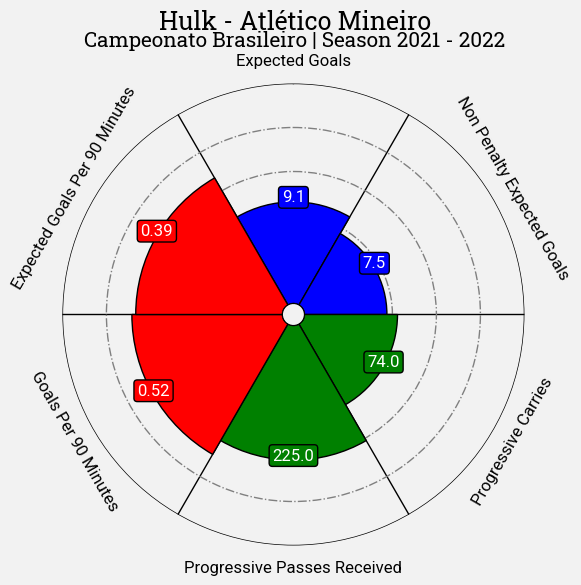

In [55]:
# código copiado do SoccerMatics

values: np.array = hulk_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Hulk - Atlético Mineiro", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do jogador Hulk mostra o que já se imagina do atleta, isto é, um marcador de gols de altíssima qualidade. Com uma média de 0.52 gols por partida, o jogador marca, aproximadamente, um gol a cada dois jogos. Um detalhe interessante é analisar a diferença entre o *Expected Goals* e o *Non Penalty Expected Goals* do jogador. É comum na internet ver piadas e memes que dizem que o atleta depende de penalidades para marcar e fazer algo nas partidas. O gráfico mostra que há, sim, uma diferença nas duas métricas medidas, ou seja, se desconsiderado a possibilidade de penalidades, ele teria um número de gols marcados menor. No entanto, isso não significa que ele seja dependente deste tipo de lance, ainda mais quando se enxerga que essa diferença é pequena, e sua métrica de *Non Penalty Expected Goals* ainda sim possui um valor considerável.

Em relação a lances progressivos, pode-se inferir que Hulk possui uma maior qualidade em se posicionar e receber passes progressivos do que gerar "arrancadas" e carregar a bola em direção ao gol, embora em diversas situações tenha tido sucesso nesse tipo de jogada. Sua evidente força física provavelmente é um fator que o leva a ser um bom receptor de passes, já que consegue controlar bem a área a sua volta empurrando os adversários e conquistando espaços que outros jogadores poderiam não conseguir.

Em suma, o *Radar Plot* permitiu inferir detalhes importantes sobre o atleta Hulk, que se mostra um artilheiro, que aproveita muito bem suas oportunidades em cobranças de pênaltis e possui uma ótima qualidade no controle de espaço e recebimento de passes.

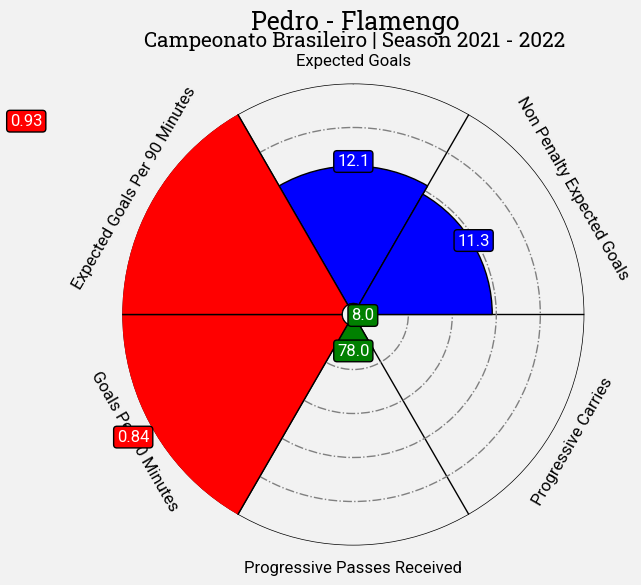

In [56]:
values: np.array = pedro_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Pedro - Flamengo", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.show()

O *Radar Plot* do Pedro é notório, já que apresenta um desbalanceamento extremamente grande entre os atributos analisados. Suas médias de *Expected Goals per 90 minutes* e *Goals per 90 minutes* preenchem os percentis porc ompleto, ou seja, dentre todos os atacantes do campeonato, ele é aquele com as melhores métricas nesses atributos. Isso não é nada fora da realidade, já que o jogador é um artilheiro de alto nível, que em 2022 apresentou tão bom desempenho que foi convocado para representar a Seleção Brasileira na Copa do Mundo do Catar. As métricas mostram que espera-se quase 1 gol por jogo para o jogador, o que é extremamente singular.

Em relação às suas métricas de gols esperados, vemos que existe uma leve diferença quando consideramos penalidades máximas, mas anda que prejudique a performance do jogador como um todo. No entanto, as métricas de lances progressivos mostram uma das grandes limitações do jogador. Ele claramente não possui qualidade de carregamento e condução de bola em direção ao gol adversário, tendo como foco total de seus atributos a finalização e a amrcação de gols. Embora possa ser argumentado que o futebol se baseie nisso, o estilo de jogo dos times pode necessitar que os jogadores possuam alguma qualidade nessas métricas de condução e recebimento de passes. 

Em suma, o *Radar Plot* mostrou que o Pedro é um grande goleador. Numericamente falando, o melhor do país no ano de 2022. Sua qualidade de finalização e conversão de chutes em gols é inegável. No entanto, pode-se notar também a limitação absurda que o joagdor tem em condução de bola e recebimento de passes progressivos.

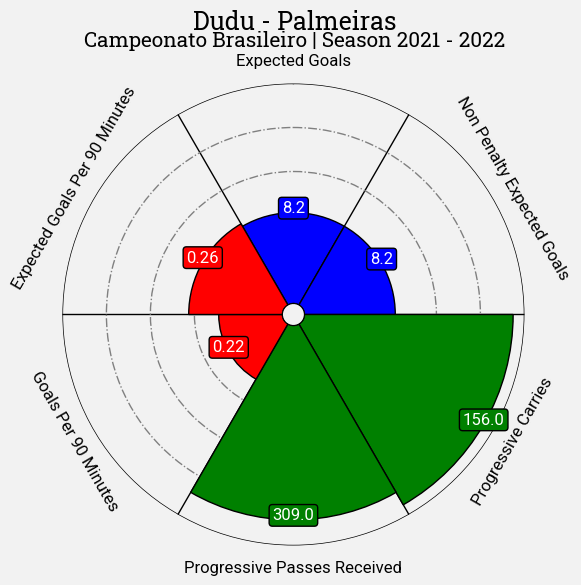

In [57]:
values: np.array = rony_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Dudu - Palmeiras", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

Em contrapartida aos outros atletas analsiados, o *Radar Plot* do Dudu mostrou que ele não possui tanta proeficiência em marcar gols e converter finalizações. Embora possua boas e consideráveis médias de *Expected Goals* e *Non Penalty Expected Goals* (inclusive, podemos notar que elas são iguais, ou seja, o atleta não depende de penalidades para marcar), esse não se mostra como seu principal atributo.

Fica evidente pelo gráfico que o jogador possui um foco muito maior na execução de jogadas progressivas. Suas métricas de *Progressive Carries* e *Progressive Passes Received* são extremamente altas, o que demonstram que o atleta tem alta habilidade na condução de bola e executa/recebe bons passes que resultam em ataques em direção ao gol do adversário.

Em resumo, o *Radar Plot* evidencia as limitações que o jogador Dudu possui na hora de marcar gols, muito provavelmente devido a sua baixa estatura e força física, que limitam sua capacidade no estilo de jogo praticado pelo palmeiras, mas sua qualidade na conversão de lances progressivos é notável.

RESUMO DOS 3

## Questão 4
- Faça o mesmo que na questão 3, mas para meio campistas.

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- PrgC (Progressive Carries): Caracterítisca importante para que possamos analisar como os meio-campistas se comportam na condução de bola, isto é, se conseguem agir bem como uma ponte entre o ataque e a defesa e levam seus times em direção ao gol do adversário.

- PrgP (Progressive Passes): Pelos mesmos motivos do atributo *PrgC*, poderemos ver como os meio-campistas contribuem com passes para a execução de lances progressivos na partida.

- GlsP90 (Goals Per 90 Minutes): Embora não seja sua principal função, se analisado um contexto geral da aprtida, um bom meio-campista também contribui diretamente com o número de gols da sua equipe, sendo efetivo em suas finalizações nos momentos oportunos.

- xGP90 (Expected Goals Per 90 Minutes): Pelas mesmas justificativas abordadas no tópico da métrica *GlsP90*, poderemos ver quantos gols espera-se que o meio-campista faça por partida.

- Assists (Assists): Um bom meio-campista contribui com assistẽncias para finalizações/gols de seus colegas de equipe. Esse atributo está atrelado diretamente aos atributos ligados a lances progressivos.

- AstP90 (Assists Per 90 Minutes): Com este atributo poderemos ver quantas assistẽncias em média o meio-campista contribui por partida ao seu time, o que demonstra um dos seus graus de contribuição com o sucesso da equipe.

Os três jogadores escolhidos serão:

- Giorgian De Arrascaeta (Flamengo)

- Raphael Veiga (Palmeiras)

- Matías Zaracho (Atlético Mineiro)

O argumento para a escolha destes três meio campistas é idêntico ao usado anteriormente. São jogadores fundamentais para seus clubes cujos desempenhos têm estado acima das demais equipes do país nos últimos anos.

In [77]:
zaracho_series: pd.Series = df[(df["Player"] == "Federico Zaracho") & (df["Squad"] == "Atlético Mineiro")]
arrascaeta_series: pd.Series = df[(df["Player"] == "Giorgian De Arrascaeta") & (df["Squad"] == "Flamengo")]
veiga_series: pd.Series = df[(df["Player"] == "Raphael Veiga") & (df["Squad"] == "Palmeiras")]

names = ["PrgC", "PrgP", "GlsP90", "xGP90", "Ast", "AstP90"]
midfielders = df[(df["Pos"].str.contains("MF")) & (df["MP"] >= 25)].describe()[names]
max_values: np.array = midfielders.loc["max"].to_numpy()
min_values: np.array = midfielders.loc["min"].to_numpy()
descriptive_names: np.array = np.array(["Progressive Carries", "Progressive Passes", "Goals Per 90 Minutes", "Expected Goals Per 90 Minutes", "Assists", "Assists Per 90 Minutes"])

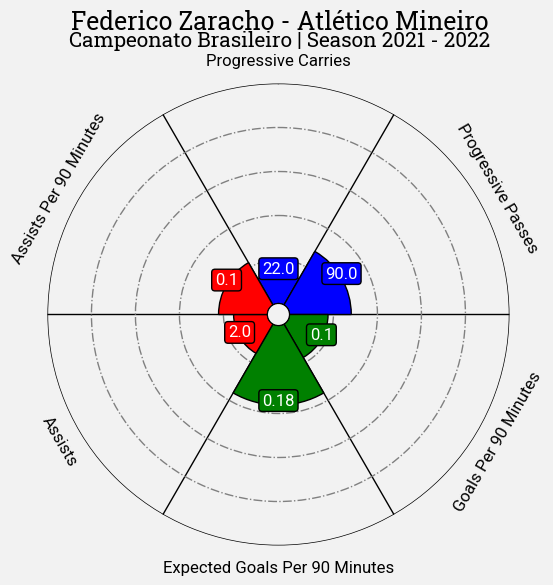

In [78]:
values: np.array = zaracho_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()

for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Federico Zaracho - Atlético Mineiro", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

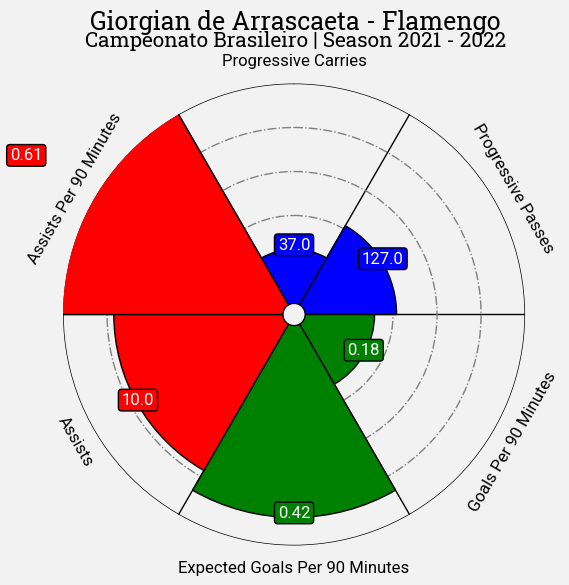

In [79]:
values: np.array = arrascaeta_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Giorgian de Arrascaeta - Flamengo", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

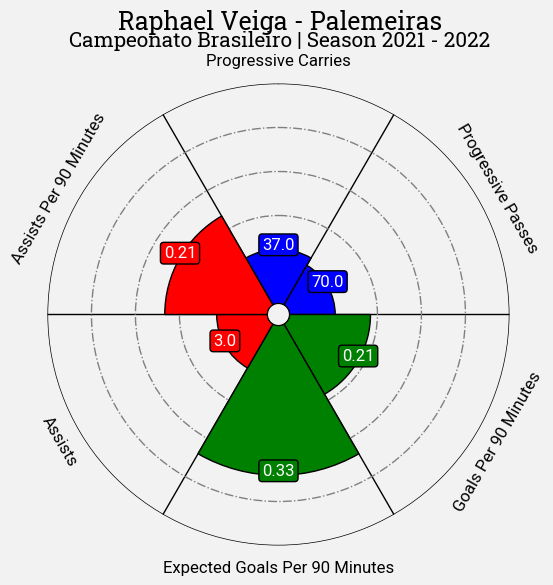

In [80]:
values: np.array = veiga_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Raphael Veiga - Palemeiras", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

## Questão 5
- Faça o mesmo que na questão 3, mas para zagueiros.

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- xG (Expected Goals): atacnate tem q fzr gol

- PrgC (Progressive Carries): podemos ver qatacantes com caracteristicas de arrancadas ao ver espaços abertos (bh, dudu, rony, hulk)

- PrgR (Progressive Passes Rec): habilidade de se posicionar para receber boas bolas e recebe las

- Gls p/ 90 - media de gols por partida, importante

- xG p/ 90 - quantos gols se espera por partida

- npxG (Non Penalty Expected Goals) - quao dependente de penaltis é esse jogador

Os três jogadores escolhidos serão:

- David Luiz (Flamengo)

- Gustavo Gómez (Palmeiras)

- Júnior Alonso (Atlético Mineiro)

O argumento para a escolha destes três zagueiros é idêntico ao usado anteriormente. São jogadores fundamentais para seus clubes cujos desempenhos têm estado acima das demais equipes do país nos últimos anos.

In [63]:
""" junior_alonso_series: pd.Series = df[(df["Player"] == "Júnior Alonso") & (df["Squad"] == "Atlético Mineiro")]
david_luiz_series: pd.Series = df[(df["Player"] == "David Luiz") & (df["Squad"] == "Flamengo")]
gustavo_gomez_series: pd.Series = df[(df["Player"] == "Gustavo Gómez") & (df["Squad"] == "Palmeiras")]

names = ["CrdY", "PrgP", "GlsP90", "xGP90", "Ast", "AstP90"]
fowards = df[(df["Pos"] == "FW") & (df["MP"] >= 25)].describe()[names]
max_values: np.array = fowards.loc["max"].to_numpy()
min_values: np.array = fowards.loc["min"].to_numpy()
descriptive_names: np.array = np.array(["Progressive Carries", "Progressive Passes", "Goals Per 90 Minutes", "Expected Goals Per 90 Minutes", "Assists", "Assists Per 90 Minutes"]) """

' junior_alonso_series: pd.Series = df[(df["Player"] == "Júnior Alonso") & (df["Squad"] == "Atlético Mineiro")]\ndavid_luiz_series: pd.Series = df[(df["Player"] == "David Luiz") & (df["Squad"] == "Flamengo")]\ngustavo_gomez_series: pd.Series = df[(df["Player"] == "Gustavo Gómez") & (df["Squad"] == "Palmeiras")]\n\nnames = ["CrdY", "PrgP", "GlsP90", "xGP90", "Ast", "AstP90"]\nfowards = df[(df["Pos"] == "FW") & (df["MP"] >= 25)].describe()[names]\nmax_values: np.array = fowards.loc["max"].to_numpy()\nmin_values: np.array = fowards.loc["min"].to_numpy()\ndescriptive_names: np.array = np.array(["Progressive Carries", "Progressive Passes", "Goals Per 90 Minutes", "Expected Goals Per 90 Minutes", "Assists", "Assists Per 90 Minutes"]) '

## Questão 6
- Discuta as diferenças entre os radares das questões 3, 4 e 5. Quais são as principais diferenças entre os atributos relevantes para cada posição? Quais são as principais semelhanças? A impressão subjetiva que você tinha dos jogadores se comprovou pelos radares? Se não, por quê? Quais posições são mais difíceis de serem avaliadas por estatísticas?